In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(len(train_data.document), len(train_data.label))
print(len(test_data.document), len(test_data.label))

150000 150000
50000 50000


In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

146182 49157
146182 49157


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
print("X_train's length :", len(X_train))
print("X_test's length :", len(X_test))

X_train's length : 146182
X_test's length : 49157


In [8]:
#전체 데이터 셋 통합
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
# padding방식을 문장 뒤쪽(post), 앞쪽(pre)중 어느쪽으로 하느냐에 따라서 성능차이 발생
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                          y_train,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=20)

In [11]:
#Conv1D
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          3616      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20
229/229 - 11s - loss: 0.4642 - accuracy: 0.7720 - val_loss: 0.3565 - val_accuracy: 0.8446
Epoch 2/20
229/229 - 2s - loss: 0.3107 - accuracy: 0.8690 - val_loss: 0.3428 - val_accuracy: 0.8518
Epoch 3/20
229/229 - 2s - loss: 0.2586 - accuracy: 0.8957 - val_loss: 0.3441 - val_accuracy: 0.8523
Epoch 4/20
229/229 - 2s - loss: 0.2027 - accuracy: 0.9235 - val_loss: 0.3769 - val_accuracy: 0.8490
Epoch 5/20
229/229 - 2s - loss: 0.1467 - accuracy: 0.9485 - val_loss: 0.4405 - val_accuracy: 0.8405
Epoch 6/20
229/229 - 2s - loss: 0.1034 - accuracy: 0.9663 - val_loss: 0.5066 - val_accuracy: 0.8387
Epoch 7/20
229/229 - 2s - loss: 0.0747 - accuracy: 0.9764 - val_loss: 0.5818 - val_accuracy: 0.8338
Epoch 8/20
229/229 - 2s - loss: 0.0572 - accuracy: 0.9826 - val_loss: 0.6515 - val_accuracy: 0.8305
Epoch 9/20
229/229 - 2s - loss: 0.0447 - accuracy: 0.9864 - val_loss: 0.7327 - val_accuracy: 0.8295
Epoch 10/20
229/229 - 2s - loss: 0.0376 - accuracy: 0.9886 - val_loss: 0.7901 - val_accuracy: 0.826

In [13]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 1.2004 - accuracy: 0.8219
[1.2004001140594482, 0.8219378590583801]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


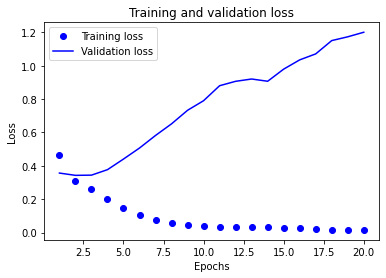

In [14]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

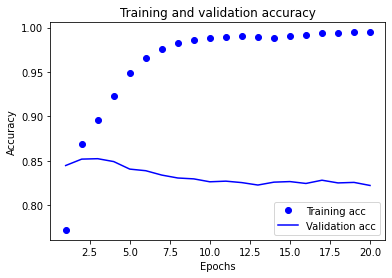

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 다른 모델들로 훈련, 그래프 그리기

In [16]:
model = keras.Sequential(name='GlobalMaxPooling1D') 
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
model.add(keras.layers.GlobalMaxPooling1D()) 
model.add(keras.layers.Dense(8, activation='relu')) 
model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. 
model.summary()

Model: "GlobalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20
229/229 - 2s - loss: 0.5903 - accuracy: 0.7272 - val_loss: 0.4456 - val_accuracy: 0.8222
Epoch 2/20
229/229 - 1s - loss: 0.3702 - accuracy: 0.8436 - val_loss: 0.3609 - val_accuracy: 0.8421
Epoch 3/20
229/229 - 1s - loss: 0.3120 - accuracy: 0.8683 - val_loss: 0.3543 - val_accuracy: 0.8447
Epoch 4/20
229/229 - 1s - loss: 0.2814 - accuracy: 0.8849 - val_loss: 0.3576 - val_accuracy: 0.8456
Epoch 5/20
229/229 - 1s - loss: 0.2582 - accuracy: 0.8960 - val_loss: 0.3663 - val_accuracy: 0.8452
Epoch 6/20
229/229 - 1s - loss: 0.2381 - accuracy: 0.9058 - val_loss: 0.3766 - val_accuracy: 0.8432
Epoch 7/20
229/229 - 1s - loss: 0.2204 - accuracy: 0.9145 - val_loss: 0.3911 - val_accuracy: 0.8414
Epoch 8/20
229/229 - 1s - loss: 0.2038 - accuracy: 0.9225 - val_loss: 0.4066 - val_accuracy: 0.8395
Epoch 9/20
229/229 - 1s - loss: 0.1882 - accuracy: 0.9301 - val_loss: 0.4243 - val_accuracy: 0.8372
Epoch 10/20
229/229 - 1s - loss: 0.1736 - accuracy: 0.9367 - val_loss: 0.4443 - val_accuracy: 0.8354

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


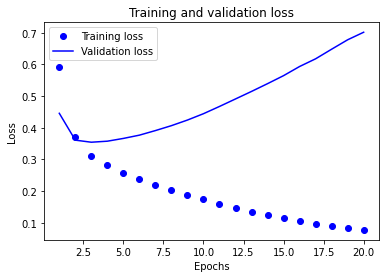

In [18]:
history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

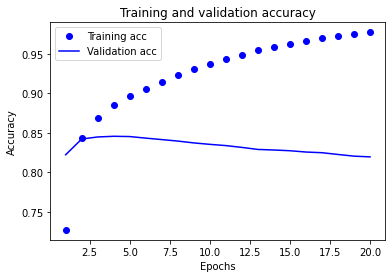

In [19]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
model = keras.Sequential(name='LSTM') 
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
model.add(keras.layers.LSTM(8)) 
model.add(keras.layers.Dense(8, activation='relu')) 
model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. 
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 321,393
Trainable params: 321,393
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20
229/229 - 5s - loss: 0.5061 - accuracy: 0.7769 - val_loss: 0.3742 - val_accuracy: 0.8406
Epoch 2/20
229/229 - 2s - loss: 0.3396 - accuracy: 0.8577 - val_loss: 0.3522 - val_accuracy: 0.8475
Epoch 3/20
229/229 - 2s - loss: 0.3139 - accuracy: 0.8685 - val_loss: 0.3526 - val_accuracy: 0.8448
Epoch 4/20
229/229 - 2s - loss: 0.3000 - accuracy: 0.8740 - val_loss: 0.3499 - val_accuracy: 0.8465
Epoch 5/20
229/229 - 2s - loss: 0.2880 - accuracy: 0.8796 - val_loss: 0.3484 - val_accuracy: 0.8464
Epoch 6/20
229/229 - 2s - loss: 0.2767 - accuracy: 0.8850 - val_loss: 0.3502 - val_accuracy: 0.8476
Epoch 7/20
229/229 - 2s - loss: 0.2647 - accuracy: 0.8902 - val_loss: 0.3565 - val_accuracy: 0.8494
Epoch 8/20
229/229 - 2s - loss: 0.2527 - accuracy: 0.8951 - val_loss: 0.3587 - val_accuracy: 0.8488
Epoch 9/20
229/229 - 2s - loss: 0.2389 - accuracy: 0.9014 - val_loss: 0.3656 - val_accuracy: 0.8498
Epoch 10/20
229/229 - 2s - loss: 0.2257 - accuracy: 0.9075 - val_loss: 0.3891 - val_accuracy: 0.8486

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


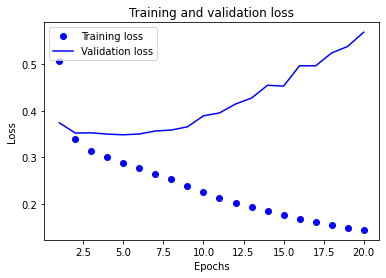

In [22]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

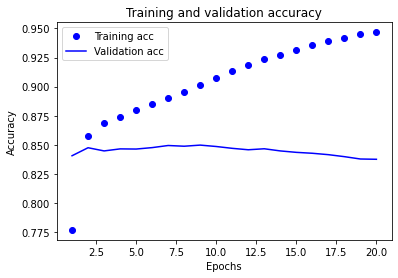

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 8) 학습된 Embedding 레이어 분석

In [24]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 32)


In [25]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀쓰기

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([ 0.01289808, -0.0317429 , -0.01142182,  0.06689011, -0.06549267,
       -0.05664063, -0.09751911, -0.00917648,  0.05196648,  0.05618934,
       -0.03709642,  0.06766177,  0.00091089, -0.09466499, -0.04806579,
       -0.13621396, -0.01736087,  0.04638767,  0.01986431,  0.06154292,
        0.11689462, -0.00655601, -0.01892465, -0.1845372 , -0.04197426,
       -0.0975717 , -0.05848823,  0.12415095, -0.11531416, -0.04473726,
        0.00161791,  0.00573489], dtype=float32)

In [27]:
word_vectors.similar_by_word("배우")

[('주문', 0.7669399976730347),
 ('이재은', 0.7520524859428406),
 ('28', 0.742764949798584),
 ('K', 0.7242842316627502),
 ('소설', 0.7204552292823792),
 ('양조위', 0.7201940417289734),
 ('미모', 0.7198936343193054),
 ('올리버', 0.707754373550415),
 ('로드', 0.7020871639251709),
 ('매료', 0.7005795240402222)]

In [28]:
word_vectors.similar_by_word("장르")

[('레즈', 0.8976573944091797),
 ('브래드피트', 0.8639897704124451),
 ('렛', 0.8634160757064819),
 ('박진영', 0.8577955365180969),
 ('내고', 0.856255829334259),
 ('치명', 0.85528564453125),
 ('련지', 0.8546164035797119),
 ('파고들', 0.8474782705307007),
 ('믹', 0.8414535522460938),
 ('매년', 0.840702474117279)]